# vLife Virtusa
## Pneumonia Diagnosis Using CNN
### Usecase Description
Pneumonia diagnosis on pediatric chest X-ray images provided by the patient using CNN. The model will predict whether the patient has pnemonia or not.Automate pneumonia diagnosis on pediatric chest X-ray images provided by the Guangzhou Women and Children’s Medical Center, Guangzhou (China). The images display both healthy and unhealthy lungs.
![](https://i.imgur.com/jZqpV51.png)
Although pneumonia can be either bacterial or viral, our goal is not to distinguish between the two types of pneumonia. We solely aim at _diagnosing_ pneumonia.


### Dataset Source
Data for this usecase can be found [here](https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia).

### Dataset Description
_The dataset is organized into 3 folders (train, test, val) and contains subfolders for each image category (Pneumonia/Normal). There are 5,863 X-Ray images (JPEG) and 2 categories (Pneumonia/Normal)._

_Chest X-ray images (anterior-posterior) were selected from retrospective cohorts of pediatric patients of one to five years old from Guangzhou Women and Children’s Medical Center, Guangzhou. All chest X-ray imaging was performed as part of patients’ routine clinical care._

_For the analysis of chest x-ray images, all chest radiographs were initially screened for quality control by removing all low quality or unreadable scans. The diagnoses for the images were then graded by two expert physicians before being cleared for training the AI system. In order to account for any grading errors, the evaluation set was also checked by a third expert_.

### Helper Functions to Explore Data

_Let us take a first look at our dataset_

In [8]:
# Load train & test data
from __future__ import division

import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt

def get_img_paths(set_folder):
    '''
    Lists all paths in a given folder
    '''
    img_paths = []
    for sub_folder in ['NORMAL', 'PNEUMONIA']:
        directory = set_folder + '/' + sub_folder
        img_paths += [directory + '/' + f for f in os.listdir(directory) if f[0] != '.']
    return img_paths

def img_path_to_np_array(path, size):
    '''
    Loads image located at path into a numpy array of shape (size, size)
    '''
    img = cv2.imread(path)   # reads an image in the BGR format
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)   # COLOR_BGR2RGB for color
    img = cv2.resize(img, dsize=(size, size), interpolation=cv2.INTER_CUBIC)
    return img

def get_label(image_path):
    '''
    Assigns a label to an image
    0 stands for healthy patient
    1 stands for pneumonia
    '''
    return 1*('virus' in image_path or 'bacteria' in image_path)

def load_data(set_folder, size):
    '''
    Loads both NORMAL & PNEUMONIA images into two numpy arrays
    '''
    img_paths = get_img_paths(set_folder)
    Y = np.array([get_label(img_path) for img_path in img_paths])
    X = np.array([img_path_to_np_array(img_path, size) for img_path in img_paths])
    X = np.reshape(X, (-1, size, size, 1))
    X = X.astype('float32')
    X = X/255
    return X, Y

size = 100 # we resize the original images into arrays of shape (size, size)
chest_xray_folder = "data/chest_xray/"
train_X, train_Y = load_data(chest_xray_folder + "/train", size)
test_X, test_Y = load_data(chest_xray_folder + "/test", size)
valid_X, valid_Y = load_data(chest_xray_folder + "/val", size)

In [9]:
train_X

array([[[[0.21176471],
         [0.27450982],
         [0.29411766],
         ...,
         [0.        ],
         [0.        ],
         [0.        ]],

        [[0.20392157],
         [0.24313726],
         [0.3019608 ],
         ...,
         [0.        ],
         [0.        ],
         [0.        ]],

        [[0.22352941],
         [0.25882354],
         [0.28627452],
         ...,
         [0.        ],
         [0.        ],
         [0.        ]],

        ...,

        [[0.        ],
         [0.        ],
         [0.06666667],
         ...,
         [0.        ],
         [0.        ],
         [0.        ]],

        [[0.        ],
         [0.        ],
         [0.05882353],
         ...,
         [0.        ],
         [0.        ],
         [0.        ]],

        [[0.        ],
         [0.        ],
         [0.04705882],
         ...,
         [0.        ],
         [0.        ],
         [0.        ]]],


       [[[0.09803922],
         [0.13333334],
         [0.18

### Exploratory Data Analysis

> **The dataset comprises a train set, a test set and a validation set. As given, the train set and the test set contain 5,216 and 624 images respectively. However, with 16 images only, the validation set is very small**

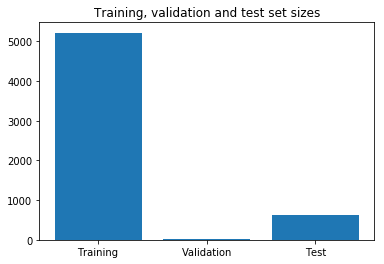

Size of the training set: 5216
Size of the test set: 624
Size of the validation set: 16


In [10]:
# Plot training, validation and test set summary
def plot_train_validation_test_summary(train_Y, valid_Y, test_Y):
    '''
    Plots training, validation and test set sizes
    '''
    bars = ('Training', 'Validation', 'Test')
    count = [train_Y.size, valid_Y.size, test_Y.size]
    pos = np.arange(len(bars))
    plt.bar(pos, count)
    plt.xticks(pos, bars)
    plt.title('Training, validation and test set sizes')
    plt.show()
    print("Size of the training set: " + str(train_Y.size))
    print("Size of the test set: " + str(test_Y.size))
    print("Size of the validation set: " + str(valid_Y.size))
    
plot_train_validation_test_summary(train_Y, valid_Y, test_Y)

> **Therefore we decided not to use the given validation set for validation but, rather, to plug it back into our training set. We then built our own validation set by randomly sampling half of the examples from the test set, yielding a validation set and a new test set. This ensures that the validation set comes from the same distribution as the test set, which is crucial in any machine learning endeavor.**

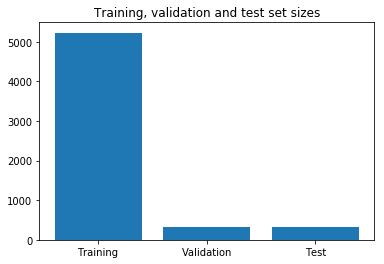

Size of the training set: 5232
Size of the test set: 312
Size of the validation set: 312


In [11]:
# add validation set back into training set and create new validation set from test set
def shuffle_randomly(X, Y):
    '''
    Shuffles X and Y TOGETHER
    '''
    randomize = np.arange(Y.size)
    np.random.shuffle(randomize)
    X, Y = X[randomize, :, :, :], Y[randomize]
    return X, Y

def concatenate_and_shuffle_randomly(X_a, Y_a, X_b, Y_b):
    '''
    Concatenates two datasets (X_a, Y_a) and (X_b, Y_b) into one new dataset (X, Y)
    '''
    X = np.concatenate((X_a, X_b), axis=0)
    Y = np.concatenate((Y_a, Y_b), axis=0)
    # shuffle X and Y TOGETHER
    X, Y = shuffle_randomly(X, Y)
    return X, Y

train_X, train_Y = concatenate_and_shuffle_randomly(train_X, train_Y, valid_X, valid_Y)

from sklearn.model_selection import train_test_split
valid_X, test_X, valid_Y, test_Y = train_test_split(test_X, test_Y, test_size=0.5, random_state=13)

plot_train_validation_test_summary(train_Y, valid_Y, test_Y)

>**Though still quite small, our validation set size is now acceptable.
One other important aspect to look at is the class balancing in the training set:**

Number of negative examples:1349
Number of positive examples:3883


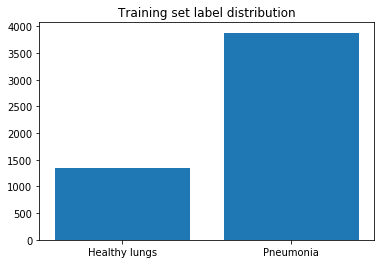

In [12]:
# Plot training data summary
def plot_data_summary(Y):
    '''
    Plots data label summary
    '''
    bars = ('Healthy lungs', 'Pneumonia')
    count = [np.sum(Y == 0), np.sum(Y == 1)]
    pos = np.arange(len(bars))
    plt.bar(pos, count)
    plt.xticks(pos, bars)
    plt.title('Training set label distribution')
    print("Number of negative examples:" + str(np.sum(Y == 0)))
    print("Number of positive examples:" + str(np.sum(Y == 1)))

plot_data_summary(train_Y)

### Predictive Deep Learning Model

The training set appears **very imbalanced, with 1,349 negative cases VS 3,883 positive cases**. Our goal in the next section will be to rebalance and "augment" the training set.
Training set augmentation consists of generating training examples ourselves, i.e. generating fake X-rays, by applying some transformations to the X-rays we already have:
* tiny rotations: if an image is a chest X-ray then a slightly rotated version of this image is also a chest X-ray
* tiny vertical & horizontal shifts: if an image is a chest X-ray then the same image shifted a little bit up, down, left or right is also a chest X-ray
* horizontal shifts: if an image is a chest X-ray then the same image flipped horizontally is also a chest X-ray (this is assuming that the human body is symmetrical, which it is not really but it turns out it does not matter in the case of pneumonia diagnosis)
* zooms: if an image is a chest X-ray then a slight zoom into this image is also a chest X-ray
* Gaussian blur: if an image is a chest X-ray then the same image slightly blurred is also a chest X-ray

To generate these new transformed images, we use the `ImageDataGenerator` function from the `keras.preprocessing.image` library for data augmentation.

Number of negative examples:50000
Number of positive examples:50000


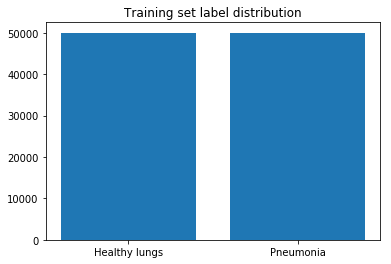

In [13]:
# Augment training data and ensure it is correctly balanced
from keras.preprocessing.image import ImageDataGenerator

def augment_data_helper(X, Y, cardinal, rotation_range, shift, horizontal_flip, zoom_range, blur_range):
    '''
    Augments data contained in X, Y by applying rotations, horizontal & vertical shifts, horizontal flips and zoom
    '''
    
    def blur(img):
        size = img.shape[0]
        blur_size = int(np.random.randint(4) * blur_range * size/3)
        if blur_size == 0:
            return img
        img = cv2.resize(img, dsize=(size, size), interpolation=cv2.INTER_CUBIC)
        img = cv2.blur(img,(blur_size, blur_size))
        img = np.reshape(img, (size, size, 1))
        return img
    
    # define an image data generator using keras ImageDataGenerator
    datagen = ImageDataGenerator(preprocessing_function= blur,
                                 rotation_range=rotation_range,
                                 width_shift_range=shift, height_shift_range=shift,
                                 horizontal_flip=horizontal_flip,
                                 zoom_range=zoom_range)
    # fit parameters from data
    datagen.fit(X)
    # configure batch size and retrieve one batch of images
    first_batch = True
    for X_batch, Y_batch in datagen.flow(X, Y, batch_size=Y.size):
        if first_batch:
            X_augmented = X_batch
            Y_augmented = Y_batch
            first_batch = False
        else:
            X_augmented = np.concatenate((X_augmented, X_batch), axis=0)
            Y_augmented = np.concatenate((Y_augmented, Y_batch), axis=0)
        if Y_augmented.size >= cardinal:
            break
    X_augmented = X_augmented[:cardinal, :, :, :]
    Y_augmented = Y_augmented[:cardinal]
    return X_augmented, Y_augmented

def augment_data(X, Y, cardinal, rotation_range, shift, horizontal_flip, zoom_range, blur_range):
    '''
    Augments data contained in X, Y by applying rotations, horizontal & vertical shifts, and horizontal flips
    Ensures the final output contains as many negative examples as positive examples
    '''
    # separate positive from negative training examples
    X_0, Y_0 = X[Y == 0], Y[Y == 0]
    X_1, Y_1 = X[Y == 1], Y[Y == 1]
    
    # augment negative and positive training examples separately
    # we want our augmented dataset to be of size cardinal
    # so we create one positive augmented subset of size cardinal/2 and one negative augmented subset of size cardinal/2
    subset_cardinal = int(cardinal/2)
    X_augmented_0, Y_augmented_0 = augment_data_helper(X_0, Y_0, subset_cardinal, rotation_range, shift, horizontal_flip, zoom_range, blur_range)
    X_augmented_1, Y_augmented_1 = augment_data_helper(X_1, Y_1, subset_cardinal, rotation_range, shift, horizontal_flip, zoom_range, blur_range)
    
    X_augmented, Y_augmented = concatenate_and_shuffle_randomly(X_augmented_0, Y_augmented_0, X_augmented_1, Y_augmented_1)
    
    return X_augmented, Y_augmented

train_X, train_Y = augment_data(train_X, train_Y, cardinal=100000, rotation_range=10, shift=0.1, horizontal_flip=True, zoom_range=0.2, blur_range=0.15)
plot_data_summary(train_Y)

> _At this time our training, test and validation sets are properly defined. Moreover, our training set is perfectly balanced with 50,000 negative and 50,000 positive examples, which add up to a total of 100,000 training examples. Let us generate some visualizations to illustrate the above mentioned data augmentation. One can see how our new training images are slightly tilted and not perfectly centered_

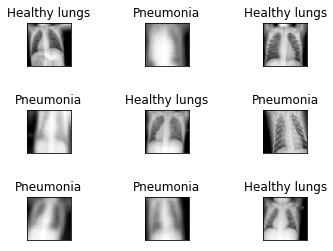

In [14]:
# Plot some training set examples to illustrate data augmentation (rotations, shifts, horizontal flips)
def plot_some_examples(X, Y, pred=None):
    '''
    Plots 9 randomly selected examples
    '''
    randomize = np.arange(Y.size)
    np.random.shuffle(randomize)
    for i in range(9):
        plt.subplot(330 + 1 + i)
        plt.imshow(X[randomize[i]].reshape(X.shape[1], X.shape[2]), cmap=plt.get_cmap('gray'))
        plt.xticks([]), plt.yticks([])
        plt.title('Pneumonia' if Y[randomize[i]] else 'Healthy lungs')
        if pred is not None:
            plt.xlabel('Actual: ' + str(Y[randomize[i]]))
            plt.title('Prediction: ' + str(pred[randomize[i]]))
    plt.subplots_adjust(hspace = 1), plt.show()
    
plot_some_examples(train_X, train_Y)

> _Let us also balance out our validation set, so as to make validation accuracy more meaningful:_

In [15]:
def balance_data(X, Y):
    '''
    Balances out labels from set by removing some of the dominant label examples
    '''
    X, Y = shuffle_randomly(X, Y)
    # separate positive from negative examples
    X_0, Y_0 = X[Y == 0], Y[Y == 0]
    X_1, Y_1 = X[Y == 1], Y[Y == 1]
    min_size = min(Y_0.size, Y_1.size)
    # subset positive and negative examples so that we end up with the same amount of each
    X_0, Y_0 = X_0[:min_size, :, :, :], Y_0[:min_size]
    X_1, Y_1 = X_1[:min_size, :, :, :], Y_1[:min_size]
    # concatenate and shuffle randomly
    X, Y = concatenate_and_shuffle_randomly(X_0, Y_0, X_1, Y_1)
    return X, Y

valid_X, valid_Y = balance_data(valid_X, valid_Y)

### Define Model Architecture

The next step is to define our machine learning model. Unsurprisingly, we will use a Convolutional Neural Network (CNN). In fact: in the past few years, CNNs have proven extremely effective at computer vision tasks, including (but not limited to) object recognition and object detection.

Using `keras.models` and `keras.layers` we will sequentially define our neural network structure:
* 3 convolutional layers
* 2 fully connected layers

In each convolutional layer we use a leaky ReLU activation, perform max pooling and apply dropout for regularization. While we use a leaky ReLU activation (along with dropout) in the first of the two fully connected layers, we use a sigmoid function in the last layer. Our final goal of binary classification motivates this choice.

In [16]:
# Convolutional Neural Network
import keras
from keras.models import Sequential, Input, Model, load_model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.layers.advanced_activations import LeakyReLU

# Initialize CNN
nn_model = Sequential()
# Convolution layer 1
nn_model.add(Conv2D(16, kernel_size=(3, 3), activation='linear', input_shape=(size, size, 1), padding='same'))
nn_model.add((LeakyReLU(alpha=0.1)))
nn_model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
nn_model.add(Dropout(0.4))
# Convolution layer 2
nn_model.add(Conv2D(32, kernel_size=(3, 3), activation='linear', padding='same'))
nn_model.add((LeakyReLU(alpha=0.1)))
nn_model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
nn_model.add(Dropout(0.4))
# Convolution layer 3
nn_model.add(Conv2D(64, kernel_size=(3, 3), activation='linear', padding='same'))
nn_model.add((LeakyReLU(alpha=0.1)))
nn_model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
nn_model.add(Dropout(0.4))
# Flat part
nn_model.add(Flatten())
nn_model.add(Dense(64, activation='linear'))
nn_model.add(LeakyReLU(alpha=0.1))
nn_model.add(Dropout(0.4))
nn_model.add(Dense(1, activation='sigmoid'))

# Compile CNN
nn_model.compile(loss=keras.losses.binary_crossentropy, optimizer=keras.optimizers.Adam(), metrics=['accuracy'])






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


### Model Training

> _We can now train our convolutional neural network. We choose to train 3 epochs with a batch size of 64.
Not too large a batch size allows our network to make progress right away rather than having to wait for an entire pass over the training set. Conversely, not too small a batch size allows us to take advantage of parallelization_

In [17]:
# Train CNN
nn_train = nn_model.fit(train_X, train_Y, batch_size=20, epochs=15, verbose=1, validation_data=(valid_X, valid_Y)) 

Train on 100000 samples, validate on 244 samples
Epoch 1/15
100000/100000 [==============================] - 75s 753us/step - loss: 0.1588 - acc: 0.9381 - val_loss: 0.7958 - val_acc: 0.8074
Epoch 2/15
100000/100000 [==============================] - 75s 751us/step - loss: 0.1592 - acc: 0.9402 - val_loss: 0.6766 - val_acc: 0.8320
Epoch 3/15
100000/100000 [==============================] - 75s 752us/step - loss: 0.1565 - acc: 0.9397 - val_loss: 0.8101 - val_acc: 0.8115
Epoch 4/15
100000/100000 [==============================] - 75s 753us/step - loss: 0.1549 - acc: 0.9403 - val_loss: 1.0365 - val_acc: 0.8033
Epoch 5/15
100000/100000 [==============================] - 75s 751us/step - loss: 0.1549 - acc: 0.9403 - val_loss: 1.0105 - val_acc: 0.8074
Epoch 6/15
100000/100000 [==============================] - 75s 755us/step - loss: 0.1517 - acc: 0.9424 - val_loss: 0.6290 - val_acc: 0.8320
Epoch 7/15
100000/100000 [==============================] - 81s 806us/step - loss: 0.1523 - acc: 0.9423 -

In [18]:
nn_model.save('Pneumonia_final_model.h5')

### Model Evaluation

> _Now that the model is trained it is time to see how good it does on the test set:_

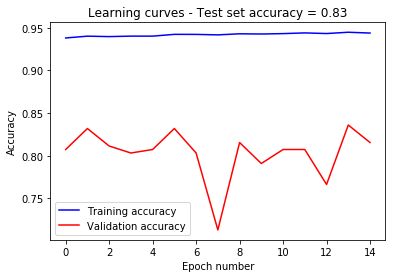

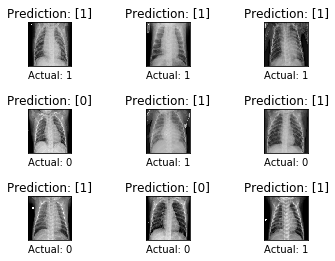

              precision    recall  f1-score   support

           0       0.97      0.54      0.70       112
           1       0.80      0.99      0.88       200

    accuracy                           0.83       312
   macro avg       0.88      0.77      0.79       312
weighted avg       0.86      0.83      0.82       312



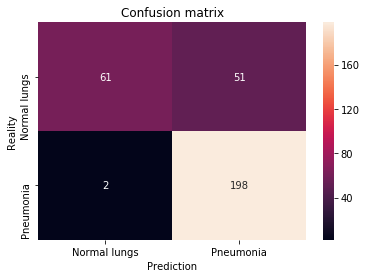

In [19]:
# Plot learning curves and compute accuracy on the test set
def plot_learning_curves(nn_train, test_X, test_Y):
    accuracy = nn_train.history['acc']
    val_accuracy = nn_train.history['val_acc']
    test_accuracy = nn_model.evaluate(test_X, test_Y, verbose=0)[1]
    epochs = range(len(accuracy))

    plt.plot(epochs, accuracy, color='blue', label='Training accuracy')
    plt.plot(epochs, val_accuracy, color='red', label='Validation accuracy')
    plt.title('Learning curves - Test set accuracy = ' + str(round(test_accuracy, 3)))
    plt.xlabel('Epoch number')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

plot_learning_curves(nn_train, test_X, test_Y)

# Plot some test set examples
test_X_for_plot, test_Y_for_plot = balance_data(test_X, test_Y)
test_predictions_for_plot = nn_model.predict_classes(test_X_for_plot)
plot_some_examples(test_X_for_plot, test_Y_for_plot, test_predictions_for_plot)

from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Confusion matrix
test_predictions = nn_model.predict_classes(test_X)
report = classification_report(test_Y, test_predictions)
confusion = confusion_matrix(test_Y, test_predictions)

# Plot confusion matrix
def plot_confusion_matrix(confusion):
    '''
    Plot confusion matrix
    '''
    ax= plt.subplot()
    sns.heatmap(confusion, annot=True, ax=ax, fmt='g'); #annot=True to annotate cells
    ax.set_xlabel('Prediction');ax.set_ylabel('Reality'); 
    ax.set_title('Confusion matrix'); 
    ax.xaxis.set_ticklabels(['Normal lungs', 'Pneumonia']); ax.yaxis.set_ticklabels(['Normal lungs', 'Pneumonia'])
    
plot_confusion_matrix(confusion)
print(report)

### Conclusion

> **We achieve a ~90% accuracy on the test set, a ~95% recall and a ~85% precision. This is a quite good accuracy considering that the neural network training lasted ~20 minutes and that the network was trained from scratch, i.e. no transfer learning.**

## END